In [1]:
import matplotlib.pyplot as plt
import numpy as np

In [3]:
errors_llama_8B_base = [ 2, 0,  22, 58, 149]
errors_llama_8B_fine = [21, 13,  24, 79, 142]

errors_mistral_base = [25, 1, 1, 65,  51]
errors_mistral_fine = [113, 0,  1, 40, 75]


errors_llama_70B_base = [33, 0,  7, 20, 8]
errors_llama_70B_fine = [0, 1,  6, 31, 44]

errors_llama_8B_base = [(a/sum(errors_llama_8B_base))*100 for a in errors_llama_8B_base]
errors_llama_8B_fine = [(a/sum(errors_llama_8B_fine))*100 for a in errors_llama_8B_fine]
#errors_mistral_base = [(a/sum(errors_mistral_base))*100 for a in errors_mistral_base]
#errors_mistral_fine = [(a/sum(errors_mistral_fine))*100 for a in errors_mistral_fine]
errors_llama_70B_base = [(a/sum(errors_llama_70B_base))*100 for a in errors_llama_70B_base]
errors_llama_70B_fine = [(a/sum(errors_llama_70B_fine))*100 for a in errors_llama_70B_fine]



data = [
    [errors_llama_8B_base, errors_llama_8B_fine],
    #[errors_mistral_base, errors_mistral_fine],
    [errors_llama_70B_base, errors_llama_70B_fine]
]
for d in zip(data):
    print(d)

([[0.8658008658008658, 0.0, 9.523809523809524, 25.108225108225106, 64.5021645021645], [7.526881720430108, 4.659498207885305, 8.60215053763441, 28.31541218637993, 50.89605734767025]],)
([[48.529411764705884, 0.0, 10.294117647058822, 29.411764705882355, 11.76470588235294], [0.0, 1.2195121951219512, 7.317073170731707, 37.80487804878049, 53.65853658536586]],)


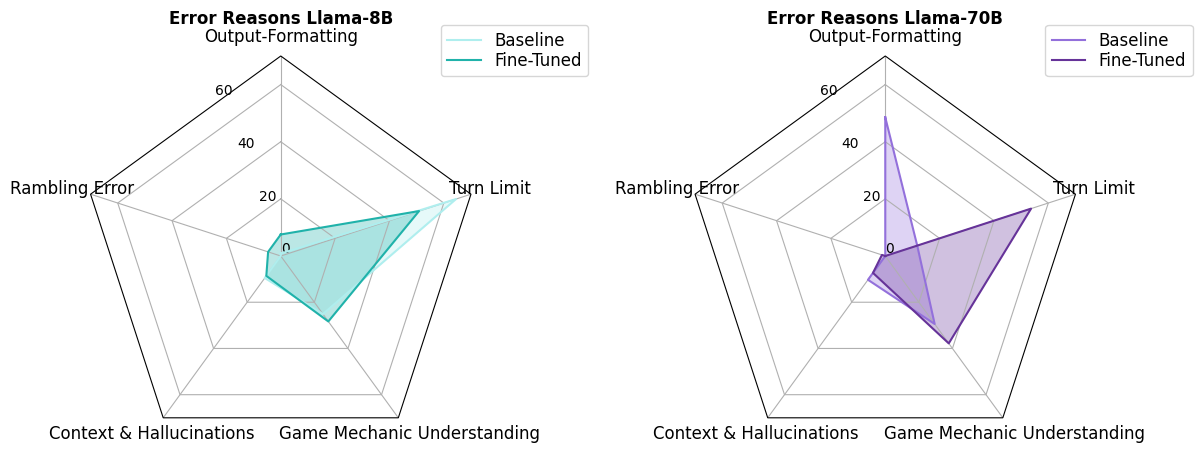

In [9]:
import matplotlib.pyplot as plt
import numpy as np

from matplotlib.patches import Circle, RegularPolygon
from matplotlib.path import Path
from matplotlib.projections import register_projection
from matplotlib.projections.polar import PolarAxes
from matplotlib.spines import Spine
from matplotlib.transforms import Affine2D


def radar_factory(num_vars, frame='circle'):
    """
    Create a radar chart with `num_vars` Axes.

    This function creates a RadarAxes projection and registers it.

    Parameters
    ----------
    num_vars : int
        Number of variables for radar chart.
    frame : {'circle', 'polygon'}
        Shape of frame surrounding Axes.

    """
    # calculate evenly-spaced axis angles
    theta = np.linspace(0, 2*np.pi, num_vars, endpoint=False)

    class RadarTransform(PolarAxes.PolarTransform):

        def transform_path_non_affine(self, path):
            # Paths with non-unit interpolation steps correspond to gridlines,
            # in which case we force interpolation (to defeat PolarTransform's
            # autoconversion to circular arcs).
            if path._interpolation_steps > 1:
                path = path.interpolated(num_vars)
            return Path(self.transform(path.vertices), path.codes)

    class RadarAxes(PolarAxes):

        name = 'radar'
        PolarTransform = RadarTransform

        def __init__(self, *args, **kwargs):
            super().__init__(*args, **kwargs)
            # rotate plot such that the first axis is at the top
            self.set_theta_zero_location('N')

        def fill(self, *args, closed=True, **kwargs):
            """Override fill so that line is closed by default"""
            return super().fill(closed=closed, *args, **kwargs)

        def plot(self, *args, **kwargs):
            """Override plot so that line is closed by default"""
            lines = super().plot(*args, **kwargs)
            for line in lines:
                self._close_line(line)

        def _close_line(self, line):
            x, y = line.get_data()
            # FIXME: markers at x[0], y[0] get doubled-up
            if x[0] != x[-1]:
                x = np.append(x, x[0])
                y = np.append(y, y[0])
                line.set_data(x, y)

        def set_varlabels(self, labels):
            self.set_thetagrids(np.degrees(theta), labels, fontsize=12)

        def _gen_axes_patch(self):
            # The Axes patch must be centered at (0.5, 0.5) and of radius 0.5
            # in axes coordinates.
            if frame == 'circle':
                return Circle((0.5, 0.5), 0.5)
            elif frame == 'polygon':
                return RegularPolygon((0.5, 0.5), num_vars,
                                      radius=.5, edgecolor="k")
            else:
                raise ValueError("Unknown value for 'frame': %s" % frame)

        def _gen_axes_spines(self):
            if frame == 'circle':
                return super()._gen_axes_spines()
            elif frame == 'polygon':
                # spine_type must be 'left'/'right'/'top'/'bottom'/'circle'.
                spine = Spine(axes=self,
                              spine_type='circle',
                              path=Path.unit_regular_polygon(num_vars))
                # unit_regular_polygon gives a polygon of radius 1 centered at
                # (0, 0) but we want a polygon of radius 0.5 centered at (0.5,
                # 0.5) in axes coordinates.
                spine.set_transform(Affine2D().scale(.5).translate(.5, .5)
                                    + self.transAxes)
                return {'polar': spine}
            else:
                raise ValueError("Unknown value for 'frame': %s" % frame)

    register_projection(RadarAxes)
    return theta

if __name__ == '__main__':
    N = 5
    theta = radar_factory(N, frame='polygon')

    # Use this for D5
    # data = example_data_per_model(models_to_consider=models_to_consider,data_quality=df_quality, data_played=df_played)
    spoke_labels = [
     'Output-Formatting',
     'Rambling Error',
     'Context & Hallucinations',
     'Game Mechanic Understanding',
    'Turn Limit',]

    titles =["Error Reasons Llama-8B","Error Reasons Llama-70B"]# ["Error Reasons Llama-8B", "Error Reasons Mistral-Small", "Error Reasons Llama-70B"]
    colors = [[ 'paleturquoise', 'lightseagreen'], ["mediumpurple", "rebeccapurple"] ]

    fig, axs = plt.subplots(figsize=(13, 5), nrows=1, ncols=2, subplot_kw=dict(projection='radar'))
    fig.subplots_adjust(wspace=0.5, hspace=0.10, top=0.85, bottom=0.05)



    # add legend relative to top-left plot
    labels = spoke_labels
    # labels = ['baseline', 'fine-tuned']


    # Plot the four cases from the example data on separate Axes
    for ax, case_data, cols, title in zip(axs.flat, data, colors, titles):
        ax.set_rgrids(list(range(0, 71, 20)))
        ax.set_ylim(0, 70)

        ax.set_title(title, weight='bold', size='large', position=(0.5, 1.1),
                     horizontalalignment='center', verticalalignment='center')
        for d, color in zip(case_data, cols):
            alpha =  0.3 if color == 'red' else 0.3
            ax.plot(theta, d, color=color)
            ax.fill(theta, d, facecolor=color, alpha=alpha, label='_nolegend_')
            ax.legend(["Baseline", "Fine-Tuned"], loc=(0.9, .95), labelspacing=0.1, fontsize='large')

        ax.set_varlabels(spoke_labels)

    plt.savefig('../../plots/final_plots/radar_chart_error_analysis.pdf', bbox_inches = "tight" )
    plt.show()
